In [1]:
import os
import sys
import glob
import os.path as path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import clear_output, display
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from skimage import color

import time
import random
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

In [2]:
manualSeed = random.randint(1, 10000)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

print("Seed:", manualSeed)

Seed: 2675


In [3]:
cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running On Cuda:", cuda)

Running On Cuda: True


In [4]:
class ColorizationDataset(Dataset):
    
    def __init__(self, paths, size):
        
        self.transforms = transforms.Compose([
            transforms.Resize((size, size), Image.BICUBIC),
            transforms.CenterCrop(size),
        ])
        
        self.size = size
        self.paths = paths
    
    def __getitem__(self, idx):
        
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = color.rgb2lab(img).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50 - 1
        ab = img_lab[[1, 2], ...] / 110
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        
        return len(self.paths)

def make_dataloaders(batch_size=64, n_workers=os.cpu_count() - 2, **kwargs):
    
    dataset = ColorizationDataset(size=256, **kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers if device == "cuda" else 0, shuffle=True)
    return dataloader

In [5]:
image_subset = 5000

train = glob.glob("../../Data/Colorization/train/*.JPEG")
test = glob.glob("../../Data/Colorization/test/*.JPEG")

print("Training Images:", len(train))
print("Test Images:", len(test))

subset_train = train[:image_subset]
subset_test = test[:image_subset]

train_dl = make_dataloaders(paths=subset_train)
test_dl = make_dataloaders(paths=subset_test)

Training Images: 178440
Test Images: 60000


In [6]:
class UnetBlock(nn.Module):
    
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False, innermost=False, outermost=False):
        
        super().__init__()
        
        self.outermost = outermost
        if input_c is None: input_c = nf
        
        downconv = nn.Conv2d(input_c, ni, kernel_size=4, stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        
        elif innermost:
            
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        
        else:
            
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        
        if self.outermost:
            
            return self.model(x)
        
        else:
            
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        
        for _ in range(n_down - 5):
            
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
       
        out_filters = num_filters * 8
        
        for _ in range(3):
            
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        
        return self.model(x)

In [7]:
class PatchDiscriminator(nn.Module):
    
    def __init__(self, input_c, num_filters=64, n_down=3):
        
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) for i in range(n_down)]
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)]                                                                 
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        return self.model(x)

In [8]:
class GANLoss(nn.Module):
   
    def __init__(self, real_label=1.0, fake_label=0.0, loss=nn.BCEWithLogitsLoss()):
        
        super().__init__()
        
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        self.loss = loss
    
    def get_labels(self, preds, target_is_real):
        
        if target_is_real:
            
            labels = self.real_label
        
        else:
            
            labels = self.fake_label
        
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [9]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        
        classname = m.__class__.__name__
        
        if hasattr(m, 'weight') and 'Conv' in classname:
            
            if init == 'norm':
                
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            
            elif init == 'xavier':
                
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            
            elif init == 'kaiming':
                
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                
                nn.init.constant_(m.bias.data, 0.0)
        
        elif 'BatchNorm2d' in classname:
            
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    return net

In [10]:
class MainModel(nn.Module):
    
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, beta1=0.5, beta2=0.999, lambda_L1=100):
        
        super().__init__()
        
        self.lambda_L1 = lambda_L1
        
        self.net_G = init_weights(Unet(input_c=1, output_c=2, n_down=8, num_filters=64).to(device))
        self.net_D = init_weights(PatchDiscriminator(input_c=3, n_down=3, num_filters=64).to(device))
        
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
        
        self.GANcriterion = GANLoss().to(device)
        self.L1criterion = nn.L1Loss()
        
    def set_requires_grad(self, model, requires_grad=True):
        
        for p in model.parameters():
            
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        
        self.L = data['L'].to(device)
        self.ab = data['ab'].to(device)
        
    def forward(self):
        
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [11]:
def lab_to_rgb(L, ab):
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    
    for img in Lab:
        
        img_rgb = color.lab2rgb(img)
        rgb_imgs.append(img_rgb)
    
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data):
    
    model.net_G.eval()
    
    with torch.no_grad():
       
        model.setup_input(data)
        model.forward()
    
    model.net_G.train()
    grey = model.L
    fake_color = model.fake_color.detach()
    real_color = model.ab
    fake_imgs = lab_to_rgb(grey, fake_color)
    real_imgs = lab_to_rgb(grey, real_color)
    
    fig = plt.figure(figsize=(15, 8))
    
    for i in range(5):
        
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(grey[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax.title.set_text("Greyscale Image")
        
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax.title.set_text("Generated Image")
       
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
        ax.title.set_text("Real Image")
    
    plt.show()

In [12]:
def train_model(epochs, verbose=False):
    
    model = MainModel()
    
    generator_loss = []
    discriminator_loss = []
    start_time = time.time()
    
    for epoch in range(epochs):
                
        print(f"\nEpoch {epoch+1}/{epochs}")             
        
        for data in tqdm(train_dl):
            
            model.setup_input(data) 
            model.optimize()
            
            g_loss = getattr(model, 'loss_G')
            d_loss = getattr(model, 'loss_D')
            
            generator_loss.append(g_loss)
            discriminator_loss.append(d_loss)
            
        clear_output(wait=True)

    if verbose:        

        print("Training Time:", time.time() - start_time, "seconds.")
        plt.figure(figsize=(10, 5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(generator_loss, label="G")
        plt.plot(discriminator_loss, label="D")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
    return model

Training Time: 113.84238004684448 seconds.


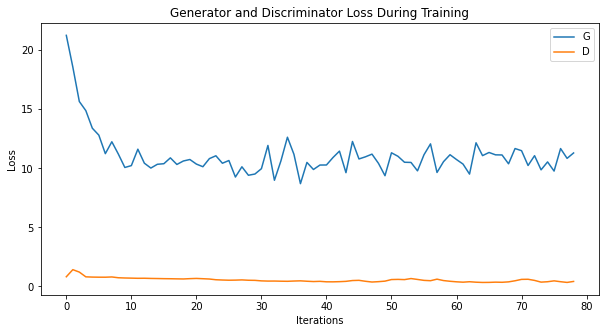

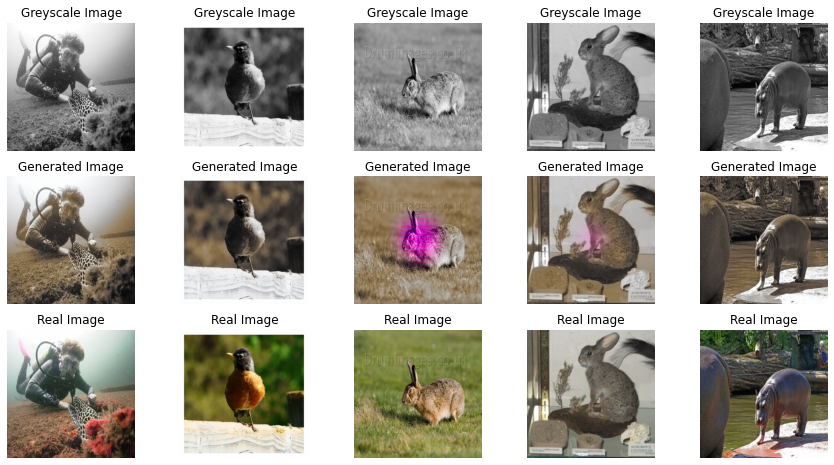

In [13]:
model = train_model(1, verbose=True)
visualize(model, next(iter(test_dl)))